In [115]:
import pandas as pd
import numpy as np
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns #heat map
from scipy.stats import pearsonr 


In [116]:
Range = np.power(2,6)

In [117]:
L_range = L_range = np.round(np.linspace(0.15, 1.5, num=Range), 4)
am_range = am_range = np.round(np.linspace(np.pi/2, 1.396, num=Range), 4) 
an_range = np.round(np.linspace(0.087, np.pi/2, num=Range), 4)

L_grid, am_grid, an_grid = np.meshgrid(L_range, am_range, an_range)


In [118]:
#Create two functions of dx and dy so we can link and evaluate how they change with different parameters


def dx(L,am,an):
    return 2 * L * np.sin(0.25*(am - an)) * np.cos(0.25*(am + an))

def dy(L,am,an):
    return (-2) * L *np.sin(0.25*(an + am)) * np.sin(0.25*(an - am))



In [119]:
# 4. Create initial DataFrame
df = pd.DataFrame({
    'L': L_grid.ravel(),
    'am': am_grid.ravel(),
    'an': an_grid.ravel()
})
cols = df.select_dtypes(include='number').columns
df[cols] = df[cols].round(3)

df['DX']=dx(df['L'],df['am'],df['an'])
df['DY']=dy(df['L'],df['am'],df['an'])

model = smf.ols('DX ~ L + am + an + L:am + L:an + am:an', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table['perc_contrib'] = 100 * anova_table['sum_sq'] / anova_table['sum_sq'].sum()
print(anova_table)

maov = MANOVA.from_formula('DX + DY ~ L + am + an', data=df)
mv_test=maov.mv_test()

print(maov.mv_test())


                sum_sq        df             F  PR(>F)  perc_contrib
L         3.268961e+03       1.0  5.371809e+07     0.0  2.764779e+01
am        6.365732e+01       1.0  1.046066e+06     0.0  5.383925e-01
an        6.876988e+03       1.0  1.130080e+08     0.0  5.816329e+01
L:am      1.465660e+01       1.0  2.408485e+05     0.0  1.239607e-01
L:an      1.583373e+03       1.0  2.601920e+07     0.0  1.339164e+01
am:an     3.253224e-29       1.0  5.345949e-25     1.0  2.751470e-31
Residual  1.595209e+01  262137.0           NaN     NaN  1.349175e-01
                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
        Intercept        Value  Num DF    Den DF    F Value   Pr > F
--------------------------------------------------------------------
           Wilks' lambda 0.8857 2.0000 262139.0000 16915.2632 0.0000
          Pillai's trace 0.1143 2.0000 262139.0000 16915

In [120]:
#sensitivity DX

def sensitivity(inputs, output):
    S = []
    for i in range(inputs.shape[1]):
        r, _ = pearsonr(inputs[:,i], output)
        S.append(abs(r))
    S = np.array(S)
    return S / S.sum()

inputs = df[['L', 'am', 'an']].values
output_dx = df['DX'].values

# Run your sensitivity function
s_indices = sensitivity(inputs, output_dx)

# Create a clean summary
sensitivity_df = pd.DataFrame({
    'Variable': ['L', 'am', 'an'],
    'Sensitivity_Index': s_indices
})

print(sensitivity_df)

  Variable  Sensitivity_Index
0        L           0.386105
1       am           0.053880
2       an           0.560015


In [121]:
#sensitivity DY

def sensitivity(inputs, output):
    S = []
    for i in range(inputs.shape[1]):
        r, _ = pearsonr(inputs[:,i], output)
        S.append(abs(r))
    S = np.array(S)
    return S / S.sum()

inputs = df[['L', 'am', 'an']].values
output_dy = df['DY'].values

# Run your sensitivity function
s_indices = sensitivity(inputs, output_dy)

# Create a clean summary
sensitivity_df = pd.DataFrame({
    'Variable': ['L', 'am', 'an'],
    'Sensitivity_Index': s_indices
})

print(sensitivity_df)

  Variable  Sensitivity_Index
0        L           0.420430
1       am           0.096739
2       an           0.482831


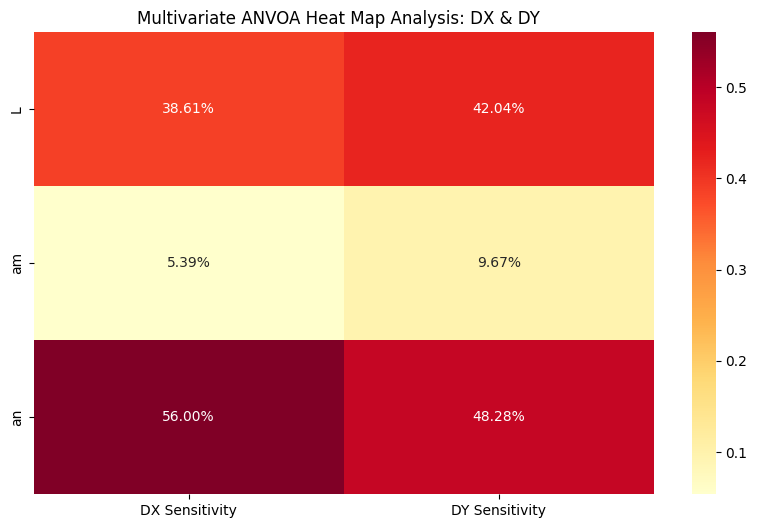

In [122]:

# 1. Define inputs for the filtered data
ivs = ['L', 'am', 'an']
X_data = df[ivs].values

# 2. Run your sensitivity function for both targets
sens_dx = sensitivity(X_data, df['DX'].values)
sens_dy = sensitivity(X_data, df['DY'].values)

# 3. Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'DX Sensitivity': sens_dx,
    'DY Sensitivity': sens_dy
}, index=ivs)

# 4. Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(comparison_df, annot=True, fmt=".2%", cmap='YlOrRd')
plt.title('Multivariate ANVOA Heat Map Analysis: DX & DY  ')
plt.show()

In [123]:

df_filtered = df[(df['DX'] >= 0.250) & (df['DX'] <= 0.255)].copy() 

cols = df_filtered.select_dtypes(include='number').columns
df_filtered[cols] = df_filtered[cols].round(3)
# print(df_filtered['DY'].agg(['min', 'max']))

# See the first 5 rows
print(df_filtered.head(5))

# See the last 5 rows
print(df_filtered.tail())

print(df_filtered['DY'].agg(['min', 'max']))


         L     am     an     DX     DY
705  0.386  1.571  0.111  0.252  0.112
772  0.407  1.571  0.181  0.251  0.118
838  0.429  1.571  0.228  0.255  0.123
905  0.450  1.571  0.299  0.251  0.127
971  0.471  1.571  0.346  0.252  0.131
            L     am     an     DX     DY
261154  1.179  1.396  0.888  0.251  0.161
261347  1.243  1.396  0.911  0.252  0.164
261540  1.307  1.396  0.935  0.251  0.165
261797  1.393  1.396  0.958  0.253  0.169
262054  1.479  1.396  0.982  0.253  0.171
min    0.100
max    0.203
Name: DY, dtype: float64


In [124]:
pd.DataFrame.to_csv(df_filtered, 'filtered_data2.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'filtered_data2.csv'